In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
from scipy import sparse 
import itertools

import matplotlib.pyplot as plt
import collections
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu


/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
outdir     = "/scr/qlyu/projects/v1/results"
outdir_fig = "/scr/qlyu/projects/v1/figures"

In [3]:
# adata = anndata.read("../../data/cheng21_cell_scrna/reorganized/allL23_typegenes_Mar29.h5ad")
# genes = adata.var.index.values
# conds = adata.obs['cond'].values
# types = adata.obs['Type'].values
# samps = adata.obs['sample'].values
# adata

In [4]:
adata_raw = anndata.read("../../data/cheng21_cell_scrna/reorganized/all_IT.h5ad")
# assert np.all(adata_raw.obs.index.values == adata.obs.index.values)
adata_raw = adata_raw[adata_raw.obs['cond']=='P38NR']
# adata_raw = adata_raw[adata_raw.obs['Subclass']!='L6IT']
counts = adata_raw.X
allgenes = adata_raw.var.index.values
# gi = basicu.get_index_from_array(allgenes, genes)
# assert np.all(gi != -1)
# counts.shape, gi.shape
adata_raw

View of AnnData object with n_obs × n_vars = 7629 × 53801
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond'

In [5]:
conds = adata_raw.obs['cond'].values
types = adata_raw.obs['Type'].values
samps = adata_raw.obs['sample'].values

In [6]:
rename_dict = {
    "L2/3_A": "L2/3_A",
    "L2/3_B": "L2/3_B",
    "L2/3_C": "L2/3_C",
    
    "L2/3_1": "L2/3_A",
    "L2/3_2": "L2/3_B",
    "L2/3_3": "L2/3_C",
    
    "L2/3_AB": "L2/3_A",
    "L2/3_BC": "L2/3_C",
}

def rename(x):
    """
    """
    if x in rename_dict.keys():
        return rename_dict[x]
    else:
        return x
    
adata_raw.obs['easitype'] = adata_raw.obs['Type'].apply(rename)

/tmp/ipykernel_1861440/1220773577.py:22: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_raw.obs['easitype'] = adata_raw.obs['Type'].apply(rename)


In [7]:
adata_raw

AnnData object with n_obs × n_vars = 7629 × 53801
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'easitype'

In [8]:
# counts - filter genes
x = adata_raw.X
cond = np.ravel((x>0).sum(axis=0)) > 10 # expressed in more than 10 cells
adata_sub = adata_raw[:,cond]
adata_sub

View of AnnData object with n_obs × n_vars = 7629 × 20420
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'easitype'

In [9]:
# counts
x = adata_sub.X
cov = adata_sub.obs['n_counts'].values
genes = adata_sub.var.index.values

# CP10k
xn = (sparse.diags(1/cov).dot(x))*1e4
# log10(CP10k+1)
xln = xn.copy()
xln.data = np.log10(xln.data+1)

adata_sub.layers['norm'] = xn
adata_sub.layers['lognorm'] = xln

In [10]:
# select HVGs with mean and var
nbin = 20
qth = 0.3

# min
gm = np.ravel(xn.mean(axis=0))

# var
tmp = xn.copy()
tmp.data = np.power(tmp.data, 2)
gv = np.ravel(tmp.mean(axis=0))-gm**2

# cut 
lbl = pd.qcut(gm, nbin, labels=np.arange(nbin))
gres = pd.DataFrame()
gres['name'] = genes
gres['lbl'] = lbl
gres['mean'] = gm
gres['var'] = gv
gres['ratio']= gv/gm

# gres = gres[gres['lbl'] != nbin-1] # remove largest bin from consideration

# select
gres_sel = gres.groupby('lbl')['ratio'].nlargest(int(qth*(len(gm)/nbin))) #.reset_index()
gsel_idx = np.sort(gres_sel.index.get_level_values(1).values)

assert np.all(gsel_idx != -1)

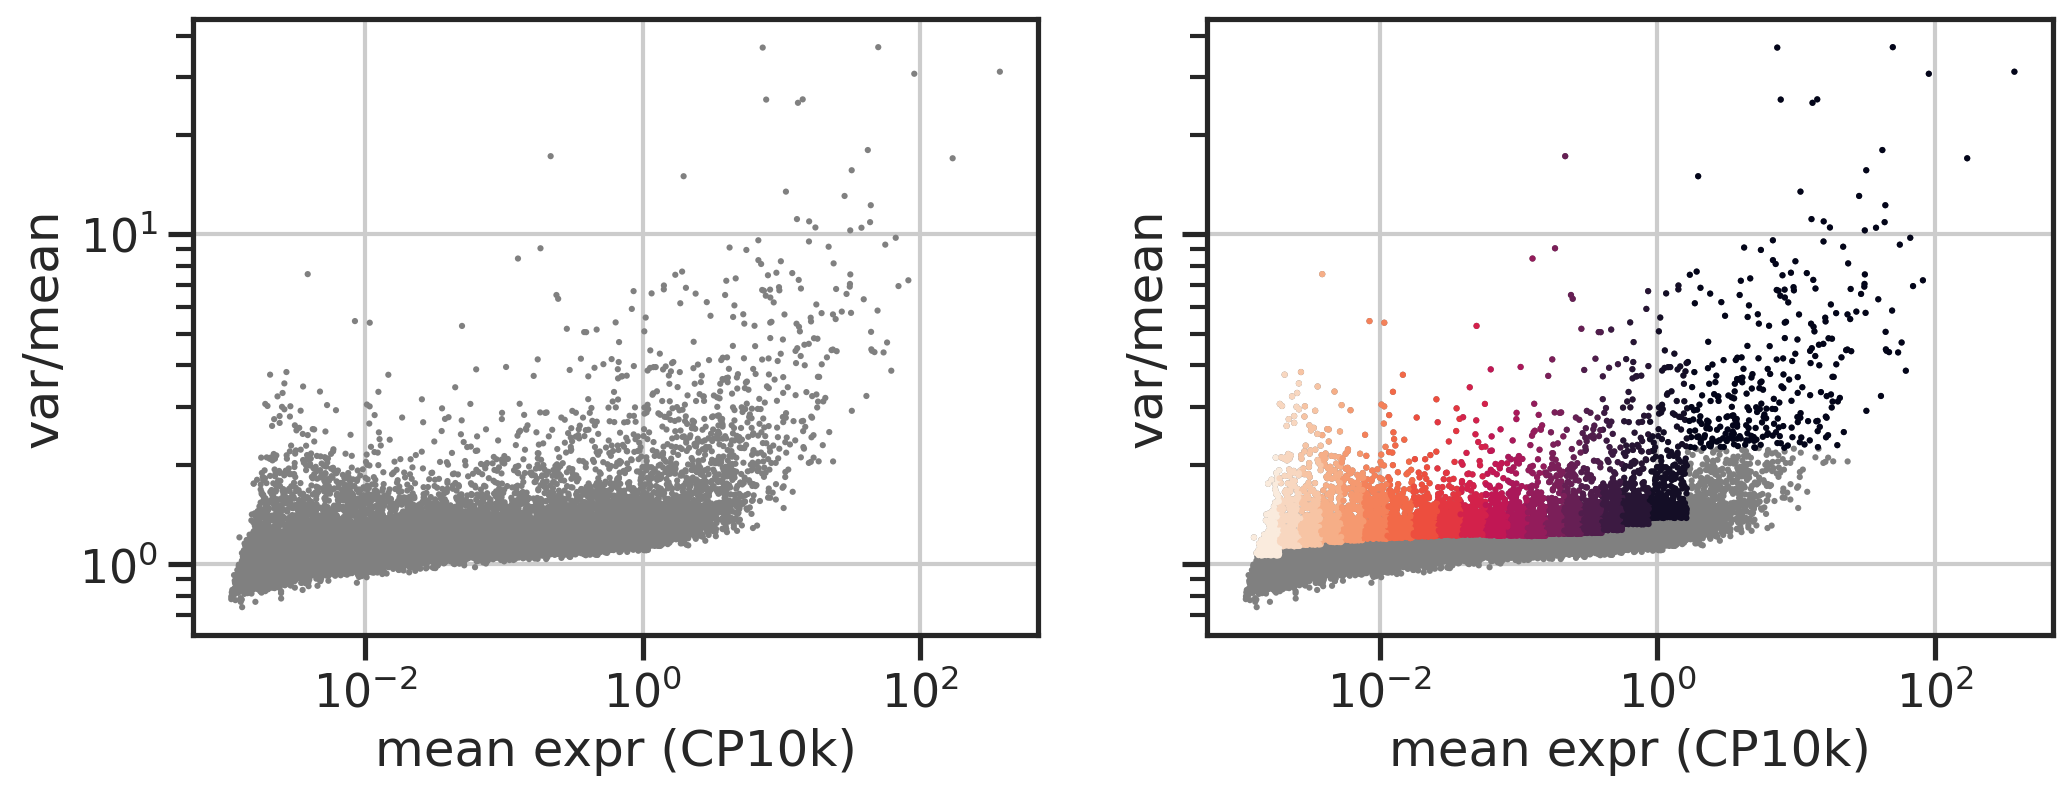

In [11]:
fig, axs = plt.subplots(1,2, figsize=(6*2,4), sharex=True, sharey=True)
ax = axs[0]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')

ax = axs[1]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.scatter(gm[gsel_idx], (gv/gm)[gsel_idx], c=lbl[gsel_idx], s=5, edgecolor='none', cmap='rocket_r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
plt.show()

In [12]:
adata_sel = adata_sub[:,gsel_idx]
adata_sel

View of AnnData object with n_obs × n_vars = 7629 × 6120
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'easitype'
    layers: 'norm', 'lognorm'

In [13]:
genes_sel = genes[gsel_idx]
genes_sel

array(['Xkr4', 'Gm1992', 'Gm37381', ..., 'mt-Nd5', 'mt-Cytb',
       'AC149090.1'], dtype=object)

In [14]:
lognorm = np.array(adata_sel.layers['lognorm'].todense())
zlognorm = zscore(lognorm, axis=0)
print(zlognorm.shape)

(7629, 6120)


In [15]:
%%time
pca = PCA(n_components=50)
pcs = pca.fit_transform(zlognorm)
# pcs = pca.fit_transform(lognorm)

ucs = UMAP(n_components=2, n_neighbors=50).fit_transform(pcs)

CPU times: user 8min 39s, sys: 30.7 s, total: 9min 10s
Wall time: 27.9 s


In [16]:
res = pd.DataFrame(pcs, columns=np.char.add("PC", ((1+np.arange(pcs.shape[1])).astype(str))))
# res['cond'] = conds
res['type'] = types
res['samp'] = samps
res['umap1'] = ucs[:,0]
res['umap2'] = ucs[:,1]
# res['type'] = types

Text(0, 0.5, 'explained var')

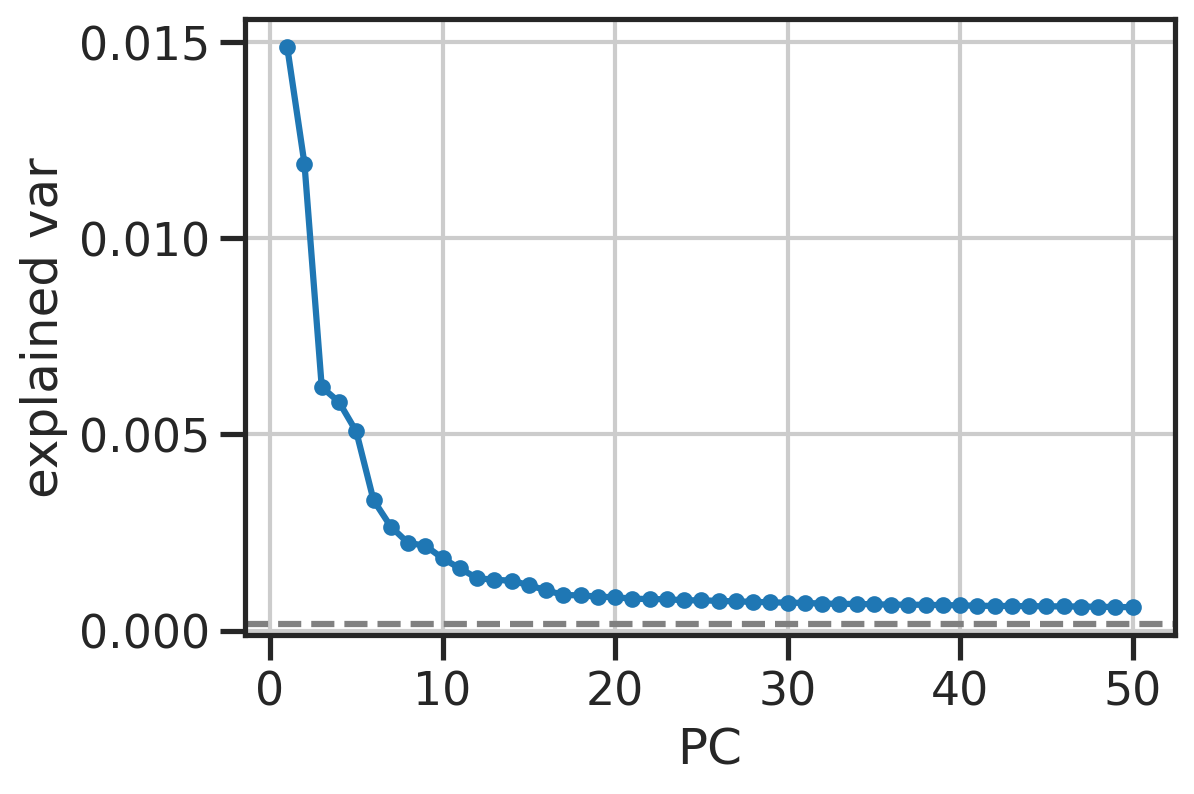

In [17]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_, '-o', markersize=5)
ax.axhline(1/lognorm.shape[1], linestyle='--', color='gray')
ax.set_xlabel('PC')
ax.set_ylabel('explained var')

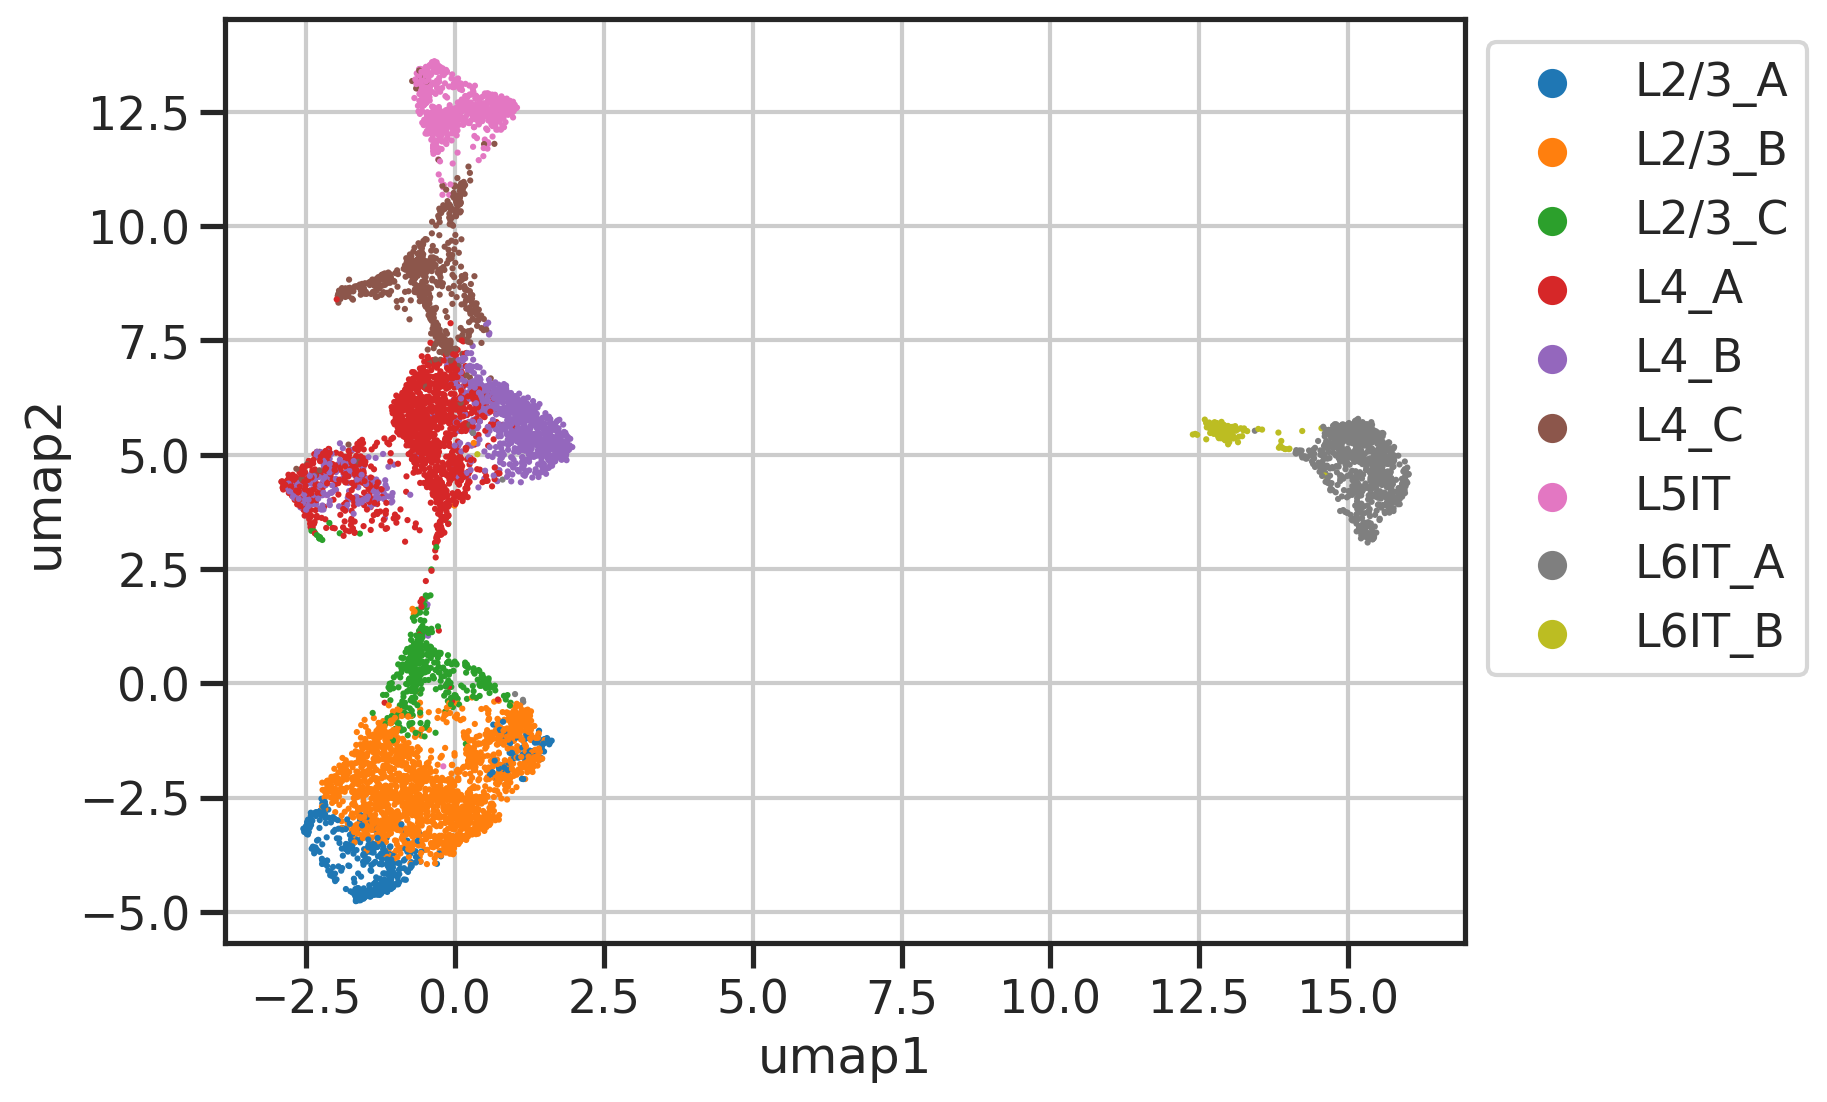

In [18]:
fig, ax = plt.subplots(1,1,figsize=(8*1,6))
sns.scatterplot(data=res.sample(frac=1, replace=False), 
                x='umap1', y='umap2', 
                hue='type',
                # hue='samp',
                # hue_order=list(palette.keys()),
                # palette=palette,
                s=5, edgecolor='none', 
                # legend=False,
                ax=ax,
               )
ax.legend(bbox_to_anchor=(1,1))
plt.show()

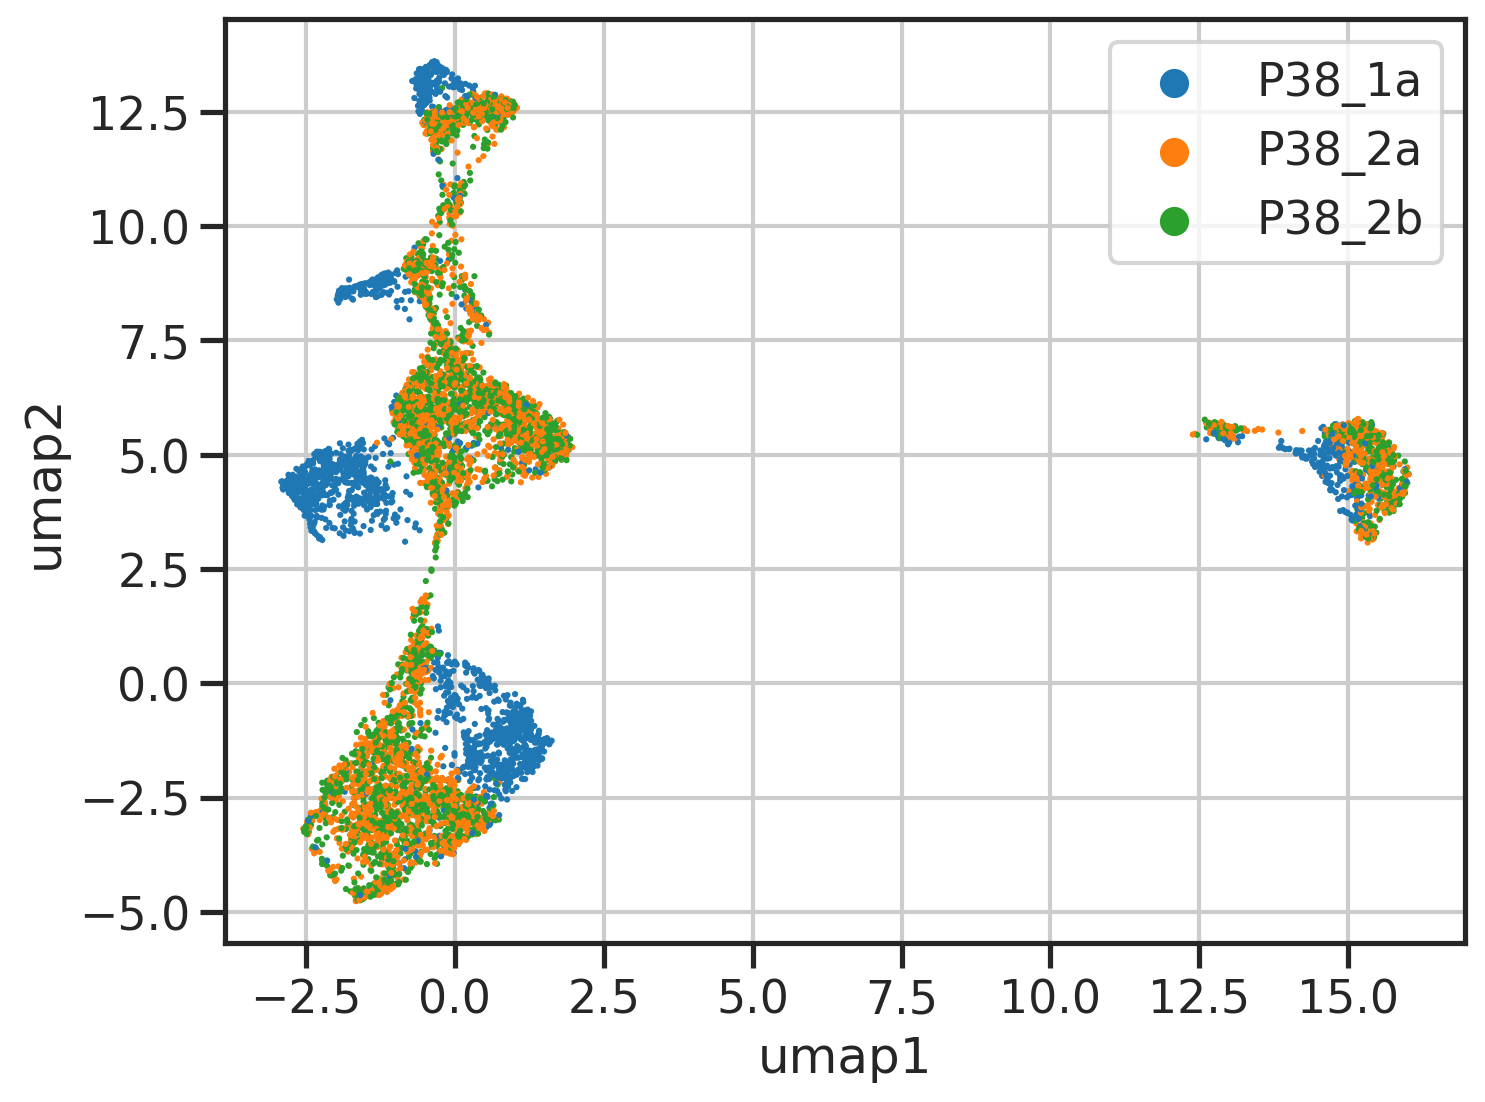

In [19]:
fig, ax = plt.subplots(1,1,figsize=(8*1,6))
sns.scatterplot(data=res.sample(frac=1, replace=False), 
                x='umap1', y='umap2', 
                # hue='type',
                hue='samp',
                # hue_order=list(palette.keys()),
                # palette=palette,
                s=5, edgecolor='none', 
                # legend=False,
                ax=ax,
               )
ax.legend(bbox_to_anchor=(1,1))
plt.show()

In [20]:
def plot_pcs(res, npc, hue):
    fig, axs = plt.subplots(npc-1,npc-1,figsize=(6*(npc-1),5*(npc-1)))
    for i, j in itertools.combinations(range(npc), 2):
        legend = False
        if (i,j) == (0,1): legend=True

        x, y = f"PC{j+1}", f"PC{i+1}"
        ax = axs[i,j-1]

        sns.scatterplot(data=res.sample(frac=1, replace=False), 
                        x=x, y=y, 
                        hue=hue,
                        # hue_order=list(palette.keys()),
                        # palette=palette,
                        s=5, edgecolor='none', 
                        legend=legend,
                        ax=ax,
                       )
        sns.despine(ax=ax)
    axs[0,0].legend(bbox_to_anchor=(0.5, -0.2), loc='upper center')

    for i, j in itertools.product(range(npc-1), range(npc-1)):
        if j<i:
            ax = axs[i,j]
            ax.axis('off')

    plt.show()

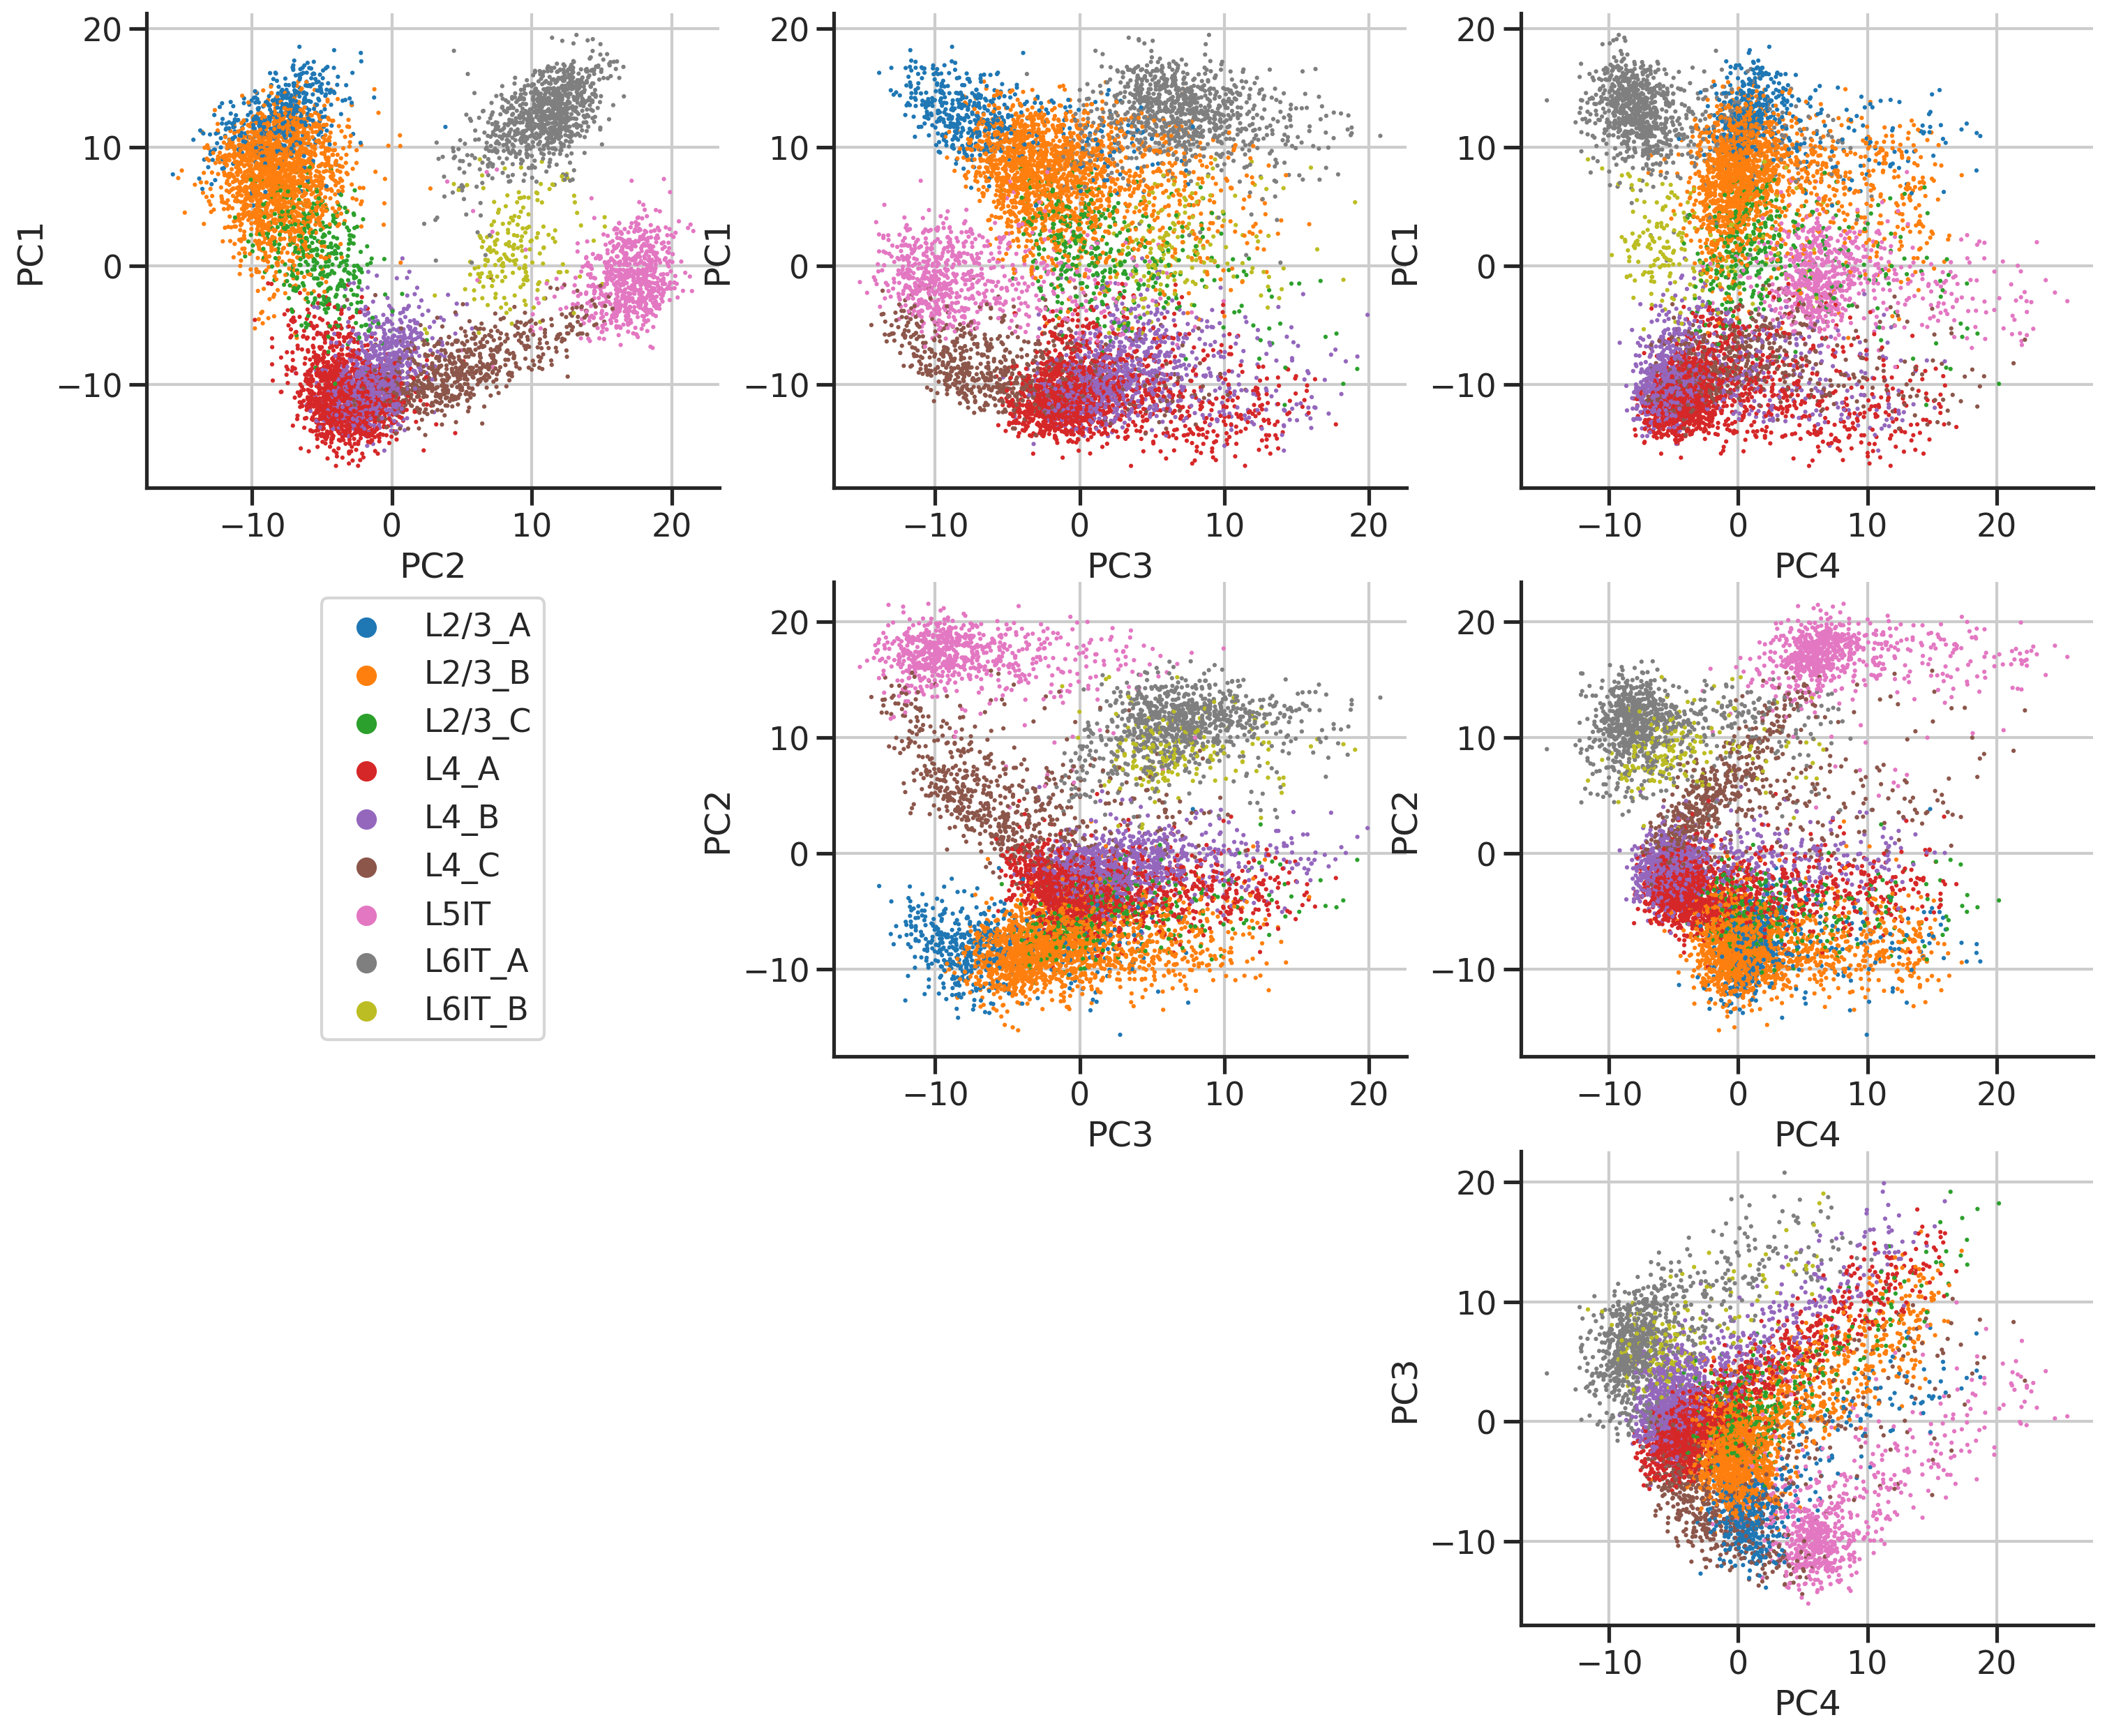

In [21]:
plot_pcs(res, 4, 'type')

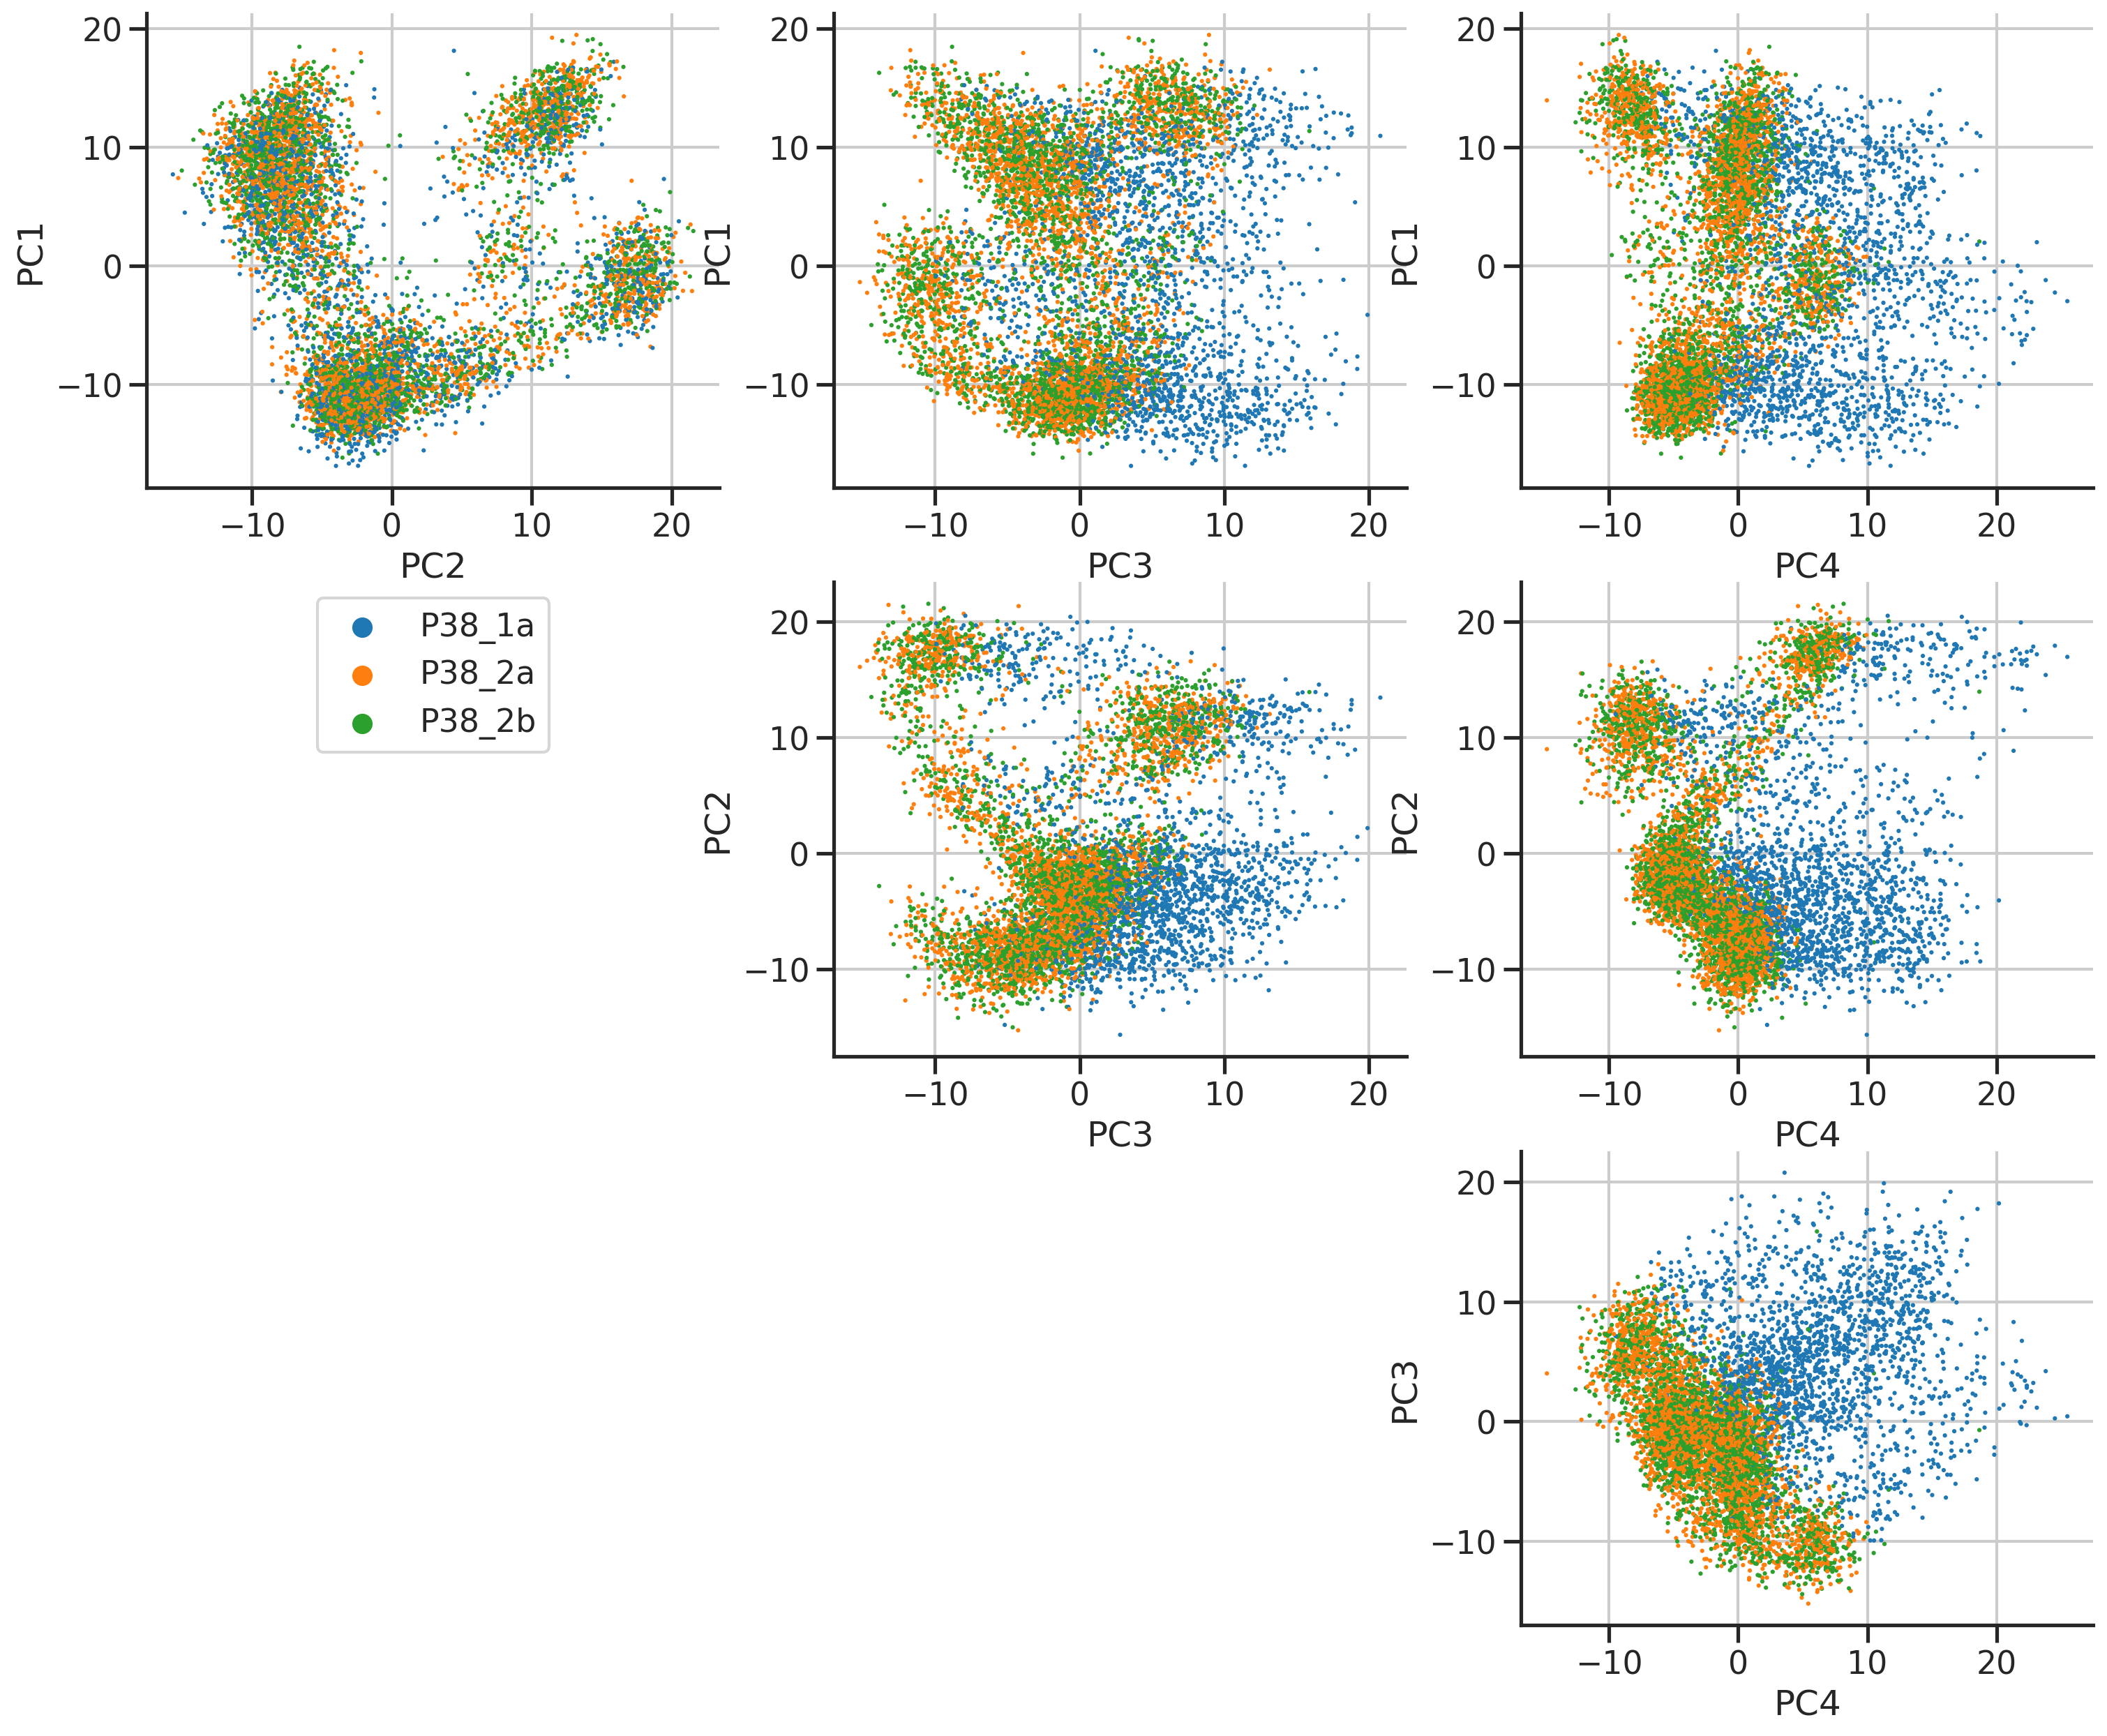

In [22]:
plot_pcs(res, 4, 'samp')

# PC4

In [23]:
pc_weights = pca.components_
pc_weights.shape

(50, 6120)

In [24]:
pc4_gidx = np.argsort(np.abs(pc_weights[3]))[::-1]
pc4_gidx_up = np.argsort(pc_weights[3])[::-1]
pc4_gidx_dn = np.argsort(-pc_weights[3])[::-1]

In [25]:
genes_sel.shape, pc4_gidx.shape

((6120,), (6120,))

In [26]:
genes_sel[pc4_gidx]

array(['Gm42418', 'Cntnap5a', 'Nrgn', ..., 'Gm4221', 'Gm19439', 'Zfp346'],
      dtype=object)

In [27]:
genes_sel[pc4_gidx_up]

array(['Gm42418', 'Cntnap5a', 'Nrgn', ..., 'Pcdh9', 'Gm44511', 'Sema3e'],
      dtype=object)

In [28]:
genes_sel[pc4_gidx_dn]

array(['Sema3e', 'Gm44511', 'Pcdh9', ..., 'Nrgn', 'Cntnap5a', 'Gm42418'],
      dtype=object)

In [31]:
adata = adata_sel

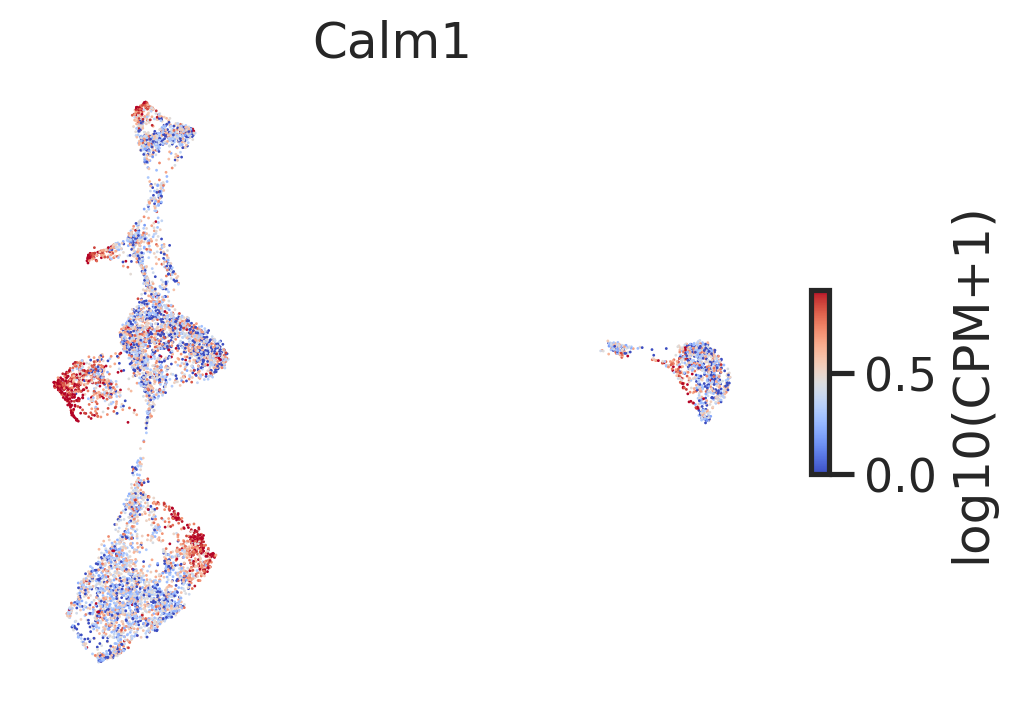

In [32]:
gene = "Calm1"
c = np.ravel(adata[:,gene].layers['lognorm'].todense())

x = ucs[:,0]
y = ucs[:,1]
vmax = np.percentile(c, 95)

fig, ax = plt.subplots(1,1,figsize=(6*1,4))
g = ax.scatter(x, y, c=c, s=1, edgecolor='none', cmap='coolwarm', vmin=0, vmax=vmax)
ax.set_title(gene)
ax.axis('off')
fig.colorbar(g, shrink=0.3, aspect=10, label='log10(CPM+1)')

plt.show()

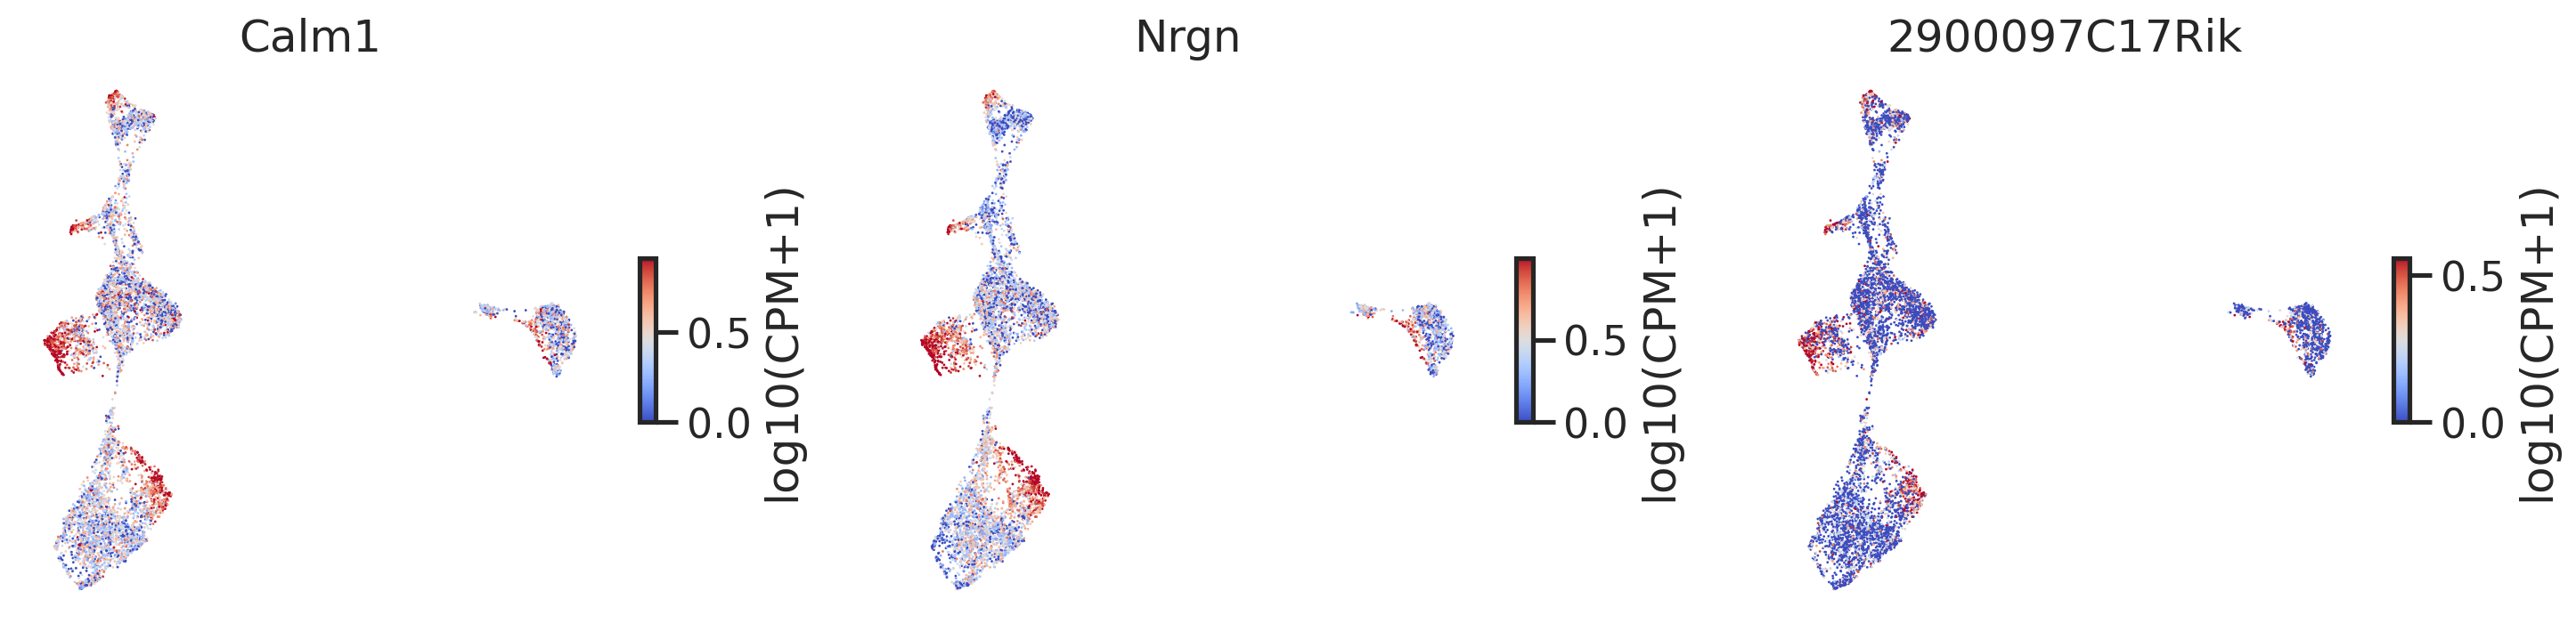

In [36]:
# genes = np.hstack([genes_sel[pc4_gidx_up][:10], genes_sel[pc4_gidx_dn][:10]])
# print(genes)


genes = [
    'Calm1',
    'Nrgn',
    '2900097C17Rik',
    # 'Nptxr', 
    # 'mt-Nd1', 
    # 'Pcsk1n', 
    # 'Aldoa',
    # 'mt-Cytb', 
    # 'Syt11', 
    # 'mt-Nd4', 
    # 'Homer1', 
    # 'Sik2', 
    # 'Ntrk2', 
    # 'Gm44511', 
    # 'Pcsk1',
    # 'Dclk1', 
    # 'Hivep2', 
    # 'Tiparp', 
    # 'Frmd6', 
    # 'R3hdm1',
]

n = len(genes)
nx = 3
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny,nx,figsize=(6*nx,4*ny))
for gene, ax in zip(genes, axs.flat):
    
    try:
        c = np.ravel(adata[:,gene].layers['lognorm'].todense())
        x = ucs[:,0]
        y = ucs[:,1]
        vmax = np.percentile(c, 95)

        g = ax.scatter(x, y, c=c, s=1, edgecolor='none', cmap='coolwarm', vmin=0, vmax=vmax)
        ax.set_title(gene)
        ax.axis('off')
        fig.colorbar(g, shrink=0.3, aspect=10, label='log10(CPM+1)')
    except:
        ax.set_title(gene)
        ax.axis('off')

plt.show()

# ptime analysis

In [ ]:
adata = adata_sel
adata

In [ ]:
adata.obsm['X_pca'] = pcs
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca')
sc.tl.diffmap(adata)
adata.uns['iroot'] = np.argmax(pcs[:,0]+pcs[:,2]) # max PC1+PC4
sc.tl.dpt(adata)
res['ptime'] = adata.obs['dpt_pseudotime'].values

In [ ]:
cellidx = np.argsort(res['ptime'].values)

# # # gene ptime
# # weights = ((lognorm+1e-10)/(lognorm.sum(axis=0)+1e-10))
# # gptime  = res['ptime'].values.dot(weights)
# # geneidx = np.argsort(gptime)

# # Use P28 ordering
# f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
# gpt = pd.read_csv(f)
# gpt = gpt['gene_ptime'].values
# geneidx2 = np.argsort(gpt)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=res, 
                x='PC1',
                y='PC2',
                hue='ptime',
                # hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
                palette='coolwarm',
               )
# ax.set_xlabel(f'PC1 ({pca_v[0]*100:.1f}% var)')
# ax.set_ylabel(f'PC2 ({pca_v[1]*100:.1f}% var)')

ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
ax.grid(False)
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(4*3,4*2), sharex=True)
for i, ax in enumerate(axs.flat):
    sns.scatterplot(data=res, 
                    x='ptime',
                    y=f'PC{i+1}',
                    hue='type',
                    edgecolor='none',
                    s=5,
                    ax=ax,
                    legend=False,
                   )
    ax.grid(False)
    sns.despine(ax=ax)
axs.flat[0].legend(bbox_to_anchor=(1,1), loc='upper left')
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
fig.subplots_adjust(wspace=0.4)
plt.show()

# check PCs - what genes?
- find some fluctuation genes?

In [ ]:
pc_weights = pca.components_
pc_weights.shape

In [ ]:
pc1_gidx = np.argsort(np.abs( pc_weights[0]))[::-1]
pc1_gidx_up =     np.argsort( pc_weights[0])[::-1]
pc1_gidx_dn =     np.argsort(-pc_weights[0])[::-1]

In [ ]:
pc2_gidx = np.argsort(np.abs(pc_weights[1]))[::-1]
pc2_gidx_up = np.argsort(pc_weights[1])[::-1]
pc2_gidx_dn = np.argsort(-pc_weights[1])[::-1]

In [ ]:
pc3_gidx = np.argsort(np.abs(pc_weights[2]))[::-1]
pc3_gidx_up = np.argsort(pc_weights[2])[::-1]
pc3_gidx_dn = np.argsort(-pc_weights[2])[::-1]

In [ ]:
pc4_gidx = np.argsort(np.abs(pc_weights[3]))[::-1]
pc4_gidx_up = np.argsort(pc_weights[3])[::-1]
pc4_gidx_dn = np.argsort(-pc_weights[3])[::-1]

In [ ]:
pc5_gidx = np.argsort(np.abs( pc_weights[4]))[::-1]
pc5_gidx_up =     np.argsort( pc_weights[4])[::-1]
pc5_gidx_dn =     np.argsort(-pc_weights[4])[::-1]

In [ ]:
lognorm = np.array(adata_sel.layers['lognorm'].todense())
zlognorm = zscore(lognorm, axis=0)

In [ ]:
mosaic = ("B"+"A"*20+"\n")*10 + ("."+"C"*20+"\n") + ("."+"D"*20+"\n")
# print(mosaic)
# gidx = np.hstack([pc4_gidx_up[:10], pc4_gidx_dn[:10]])
# gidx = np.hstack([pc1_gidx_up[:10], pc1_gidx_dn[:10]])
# gidx = np.hstack([pc2_gidx_up[:10], pc2_gidx_dn[:10]])
gidx = np.hstack([
    pc1_gidx_up[:10], pc1_gidx_dn[:10], 
    pc2_gidx_up[:10], pc2_gidx_dn[:10], 
    pc3_gidx_up[:10], pc3_gidx_dn[:10], 
    # pc4_gidx_up[:10], pc4_gidx_dn[:10], 
    pc5_gidx_up[:10], pc5_gidx_dn[:10], 
])

fig, axdict = plt.subplot_mosaic(mosaic, figsize=(12,7))
ax = axdict['A']
sns.heatmap(zlognorm[cellidx][:,gidx].T,
            xticklabels=False,
            yticklabels=False,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            rasterized=True,
            ax=ax,
           )

# ax = axdict['B']
# sns.heatmap(pd.factorize(genes_grp[geneidx], sort=True)[0].reshape(-1,1), 
#             xticklabels=False,
#             yticklabels=100,
#             cmap=cmap_d1,
#             cbar=False,
#             rasterized=True,
#             ax=ax, 
#            )
# ax.set_ylabel('Genes')
# ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

# ax = axdict['C']
# sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
#             xticklabels=False,
#             yticklabels=False,
#             # cmap=cmap_d1,
#             cbar_kws=dict(ticks=[0,1,2], shrink=1.2, aspect=3, label='type'),
#             rasterized=True,
#             ax=ax, 
#            )
# fig.axes[-1].set_yticklabels(['A','B','C'], fontsize=10)
# fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')

# ax = axdict['D']
# sns.heatmap(pd.factorize(samps[cellidx], sort=True)[0].reshape(-1,1).T, 
#             xticklabels=1000,
#             yticklabels=False,
#             # cmap=cmap_d2,
#             cbar_kws=dict(ticks=[], shrink=1.2, aspect=3, label='sample'),
#             rasterized=True,
#             ax=ax, 
#            )
# ax.set_xlabel('Cells')
# fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')
# ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

# fig.subplots_adjust(hspace=0.5)
# fig.suptitle(sample)
# powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v4.pdf'))
plt.show()

In [ ]:
mosaic = ("B"+"A"*20+"\n")*10 + ("."+"C"*20+"\n") + ("."+"D"*20+"\n")
# print(mosaic)
# gidx = np.hstack([pc4_gidx_up[:10], pc4_gidx_dn[:10]])
# gidx = np.hstack([pc1_gidx_up[:10], pc1_gidx_dn[:10]])
# gidx = np.hstack([pc2_gidx_up[:10], pc2_gidx_dn[:10]])
gidx = np.hstack([
    pc4_gidx_up[:10], pc4_gidx_dn[:10], 
])

fig, axdict = plt.subplot_mosaic(mosaic, figsize=(12,7))
ax = axdict['A']
sns.heatmap(zlognorm[cellidx][:,gidx].T,
            xticklabels=False,
            yticklabels=False,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            rasterized=True,
            ax=ax,
           )

# ax = axdict['B']
# sns.heatmap(pd.factorize(genes_grp[geneidx], sort=True)[0].reshape(-1,1), 
#             xticklabels=False,
#             yticklabels=100,
#             cmap=cmap_d1,
#             cbar=False,
#             rasterized=True,
#             ax=ax, 
#            )
# ax.set_ylabel('Genes')
# ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

# ax = axdict['C']
# sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
#             xticklabels=False,
#             yticklabels=False,
#             # cmap=cmap_d1,
#             cbar_kws=dict(ticks=[0,1,2], shrink=1.2, aspect=3, label='type'),
#             rasterized=True,
#             ax=ax, 
#            )
# fig.axes[-1].set_yticklabels(['A','B','C'], fontsize=10)
# fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')

# ax = axdict['D']
# sns.heatmap(pd.factorize(samps[cellidx], sort=True)[0].reshape(-1,1).T, 
#             xticklabels=1000,
#             yticklabels=False,
#             # cmap=cmap_d2,
#             cbar_kws=dict(ticks=[], shrink=1.2, aspect=3, label='sample'),
#             rasterized=True,
#             ax=ax, 
#            )
# ax.set_xlabel('Cells')
# fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')
# ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

# fig.subplots_adjust(hspace=0.5)
# fig.suptitle(sample)
# powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v4.pdf'))
plt.show()

# order genes?
- genes mark ptime?
- genes were reused?

In [ ]:
omat = zlognorm[cellidx]
omat

In [ ]:
x = res['ptime'].values[cellidx]

In [ ]:
%%time
nbins = 20
xb = pd.cut(x, nbins, labels=np.arange(nbins))

mi = []
for i in np.arange(omat.shape[1]):
    y = omat[:,i]
    yb = pd.cut(y, nbins, labels=np.arange(nbins))
    _mi = metrics.mutual_info_score(xb, yb)
    mi.append(_mi)
mi = np.array(mi)

In [ ]:
plt.plot(np.sort(mi))
plt.ylabel('MI')
plt.xlabel('genes')

In [ ]:
mi_idx = np.argsort(mi)[::-1]

In [ ]:
genes_sel[mi_idx]

In [ ]:
# plt.scatter(np.arange(len(omat)), omat[:,pc4_gidx[0]], s=1)
# plt.scatter(np.arange(len(omat)), omat[:,pc4_gidx[1]], s=1)
# plt.scatter(np.arange(len(omat)), omat[:,pc4_gidx[2]], s=1)

In [ ]:
for i in range(3):
    plt.scatter(np.arange(len(omat)), omat[:,mi_idx[i]], s=1)

In [ ]:
for i in range(2):
    plt.scatter(res['ptime'].values[cellidx], omat[:,mi_idx[i]], s=1)

In [ ]:
for i in range(3):
    plt.scatter(np.arange(len(omat)), omat[:,mi_idx[-i]], s=1)

In [ ]:
np.sum(mi > 0.1)

In [ ]:
adata_sel2 = adata_sel[:,mi>0.1]
adata_sel2

In [ ]:
lognorm = np.array(adata_sel2.layers['lognorm'].todense())
zlognorm = zscore(lognorm, axis=0)

In [ ]:
# # gene ptime
weights = ((lognorm+1e-10)/(lognorm.sum(axis=0)+1e-10))
gptime  = res['ptime'].values.dot(weights)
geneidx = np.argsort(gptime)

In [ ]:

mosaic = ("B"+"A"*20+"\n")*10 + ("."+"C"*20+"\n") + ("."+"D"*20+"\n")
# print(mosaic)

fig, axdict = plt.subplot_mosaic(mosaic, figsize=(12,7))
ax = axdict['A']
sns.heatmap(zlognorm[cellidx][:,geneidx].T,
            xticklabels=False,
            yticklabels=False,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            rasterized=True,
            ax=ax,
           )

# ax = axdict['B']
# sns.heatmap(pd.factorize(genes_grp[geneidx], sort=True)[0].reshape(-1,1), 
#             xticklabels=False,
#             yticklabels=100,
#             cmap=cmap_d1,
#             cbar=False,
#             rasterized=True,
#             ax=ax, 
#            )
# ax.set_ylabel('Genes')
# ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

ax = axdict['C']
sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=False,
            yticklabels=False,
            # cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=1.2, aspect=3, label='type'),
            rasterized=True,
            ax=ax, 
           )
fig.axes[-1].set_yticklabels(['A','B','C'], fontsize=10)
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')

ax = axdict['D']
sns.heatmap(pd.factorize(samps[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            # cmap=cmap_d2,
            cbar_kws=dict(ticks=[], shrink=1.2, aspect=3, label='sample'),
            rasterized=True,
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

fig.subplots_adjust(hspace=0.5)
# fig.suptitle(sample)
# powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v4.pdf'))
plt.show()

# check DEGs 